# DS Screening Challenge
### Author: Max Sop
### Contact: m.sop@hotmail.com
**Summary**

Due to time constraint and other priorities, I only explored one classifier, Random Forest, in the process of solving this challenge. Ideally one would explore at least three models and/or even aggregate them in order to obtain the most accurate predictions. The choice of RF was based on the fact that these data were highly non-linear and mostly discrete variables. Other good choices of models to try would have been Extreme Boosting.

My primary error metrics were the recall and the area under the ROC curve, given that this was a binary classification. So we aimed to optimize those metrics. In practice having some understanding of the business context or business objective is very helpful in making some of these decisions.

Given the imbalance distribution of the outcome variable, one other avenue to explore might have been to over-sample the minority class or under-sample the majority class using something like the synthetic minority over sampling technique (SMOTE). From my personal experience though it doesn't always work in improving the model performance, and one can easily get it wrong, especially within a cross-validation environment. Luckily, the RF model as implemented in sklearn can slightly address the problem with its weight balancing parameter.

Overall we built a model that got [0.68, 0.72] recall, [0.68.4, 0.71] specificity, and [0.69, 0.70] ROC_AUC scores.

In [1]:
#plotting modules
import matplotlib
import matplotlib.pyplot as plt
import featuretools as ft
import os
import sys

import numpy as np
import pandas as pd
import folium

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, make_scorer, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.preprocessing import RobustScaler, QuantileTransformer, PolynomialFeatures, LabelEncoder
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
from sklearn.pipeline import Pipeline
from collections import defaultdict


# To plot pretty figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT = 'DS_CHALLENGE'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT)
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, this_path=IMAGES_PATH):
    path = os.path.join(this_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.float_format = '{:.3f}'.format

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# to make this notebook's output stable across runs
np.random.seed(42)

Load in the training and testing data

In [2]:
org_data  = pd.read_csv('C://Users/msop/oaf/analysis/Farmer_default_model/dftRoadSafety_Accidents_2016.csv', low_memory=False)

## Data Exploration

We will start by inspecting the data. We want to see whether there are missing values and what are their distributions. We're also interested in whether they are outliers and what class (outcome variable) they represent, and any other obvious oddities inside these data set and potentially apply corrective measures whenever applicable.

In [3]:
input_data = org_data.copy()

In [4]:
input_data.shape
input_data.head()

(136621, 32)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2016010000005,519310.000,188730.000,-0.279,51.585,1,3,2,1,01/11/2016,3,02:30,28,E09000005,3,4006,6,30.000,0,-1,-1,0,0,0,5,1,1,0,0,1,1,E01000543
1,2016010000006,551920.000,174560.000,0.185,51.450,1,3,1,1,01/11/2016,3,00:37,18,E09000004,3,207,6,30.000,9,4,6,0,0,0,4,1,1,0,0,1,1,E01000375
2,2016010000008,505930.000,183850.000,-0.474,51.544,1,3,1,1,01/11/2016,3,01:25,26,E09000017,3,4020,1,30.000,1,4,3,4020,0,0,4,1,1,0,0,1,1,E01033725
3,2016010000016,527770.000,168930.000,-0.164,51.405,1,3,1,1,01/11/2016,3,09:15,22,E09000024,3,217,6,30.000,3,2,3,217,0,0,1,1,1,0,0,1,1,E01003379
4,2016010000018,510740.000,177230.000,-0.407,51.483,1,3,2,1,01/11/2016,3,07:53,25,E09000018,3,312,3,40.000,0,-1,-1,0,0,0,1,1,1,0,0,1,1,E01002583


Let's drop rows with missing Geo-location information. We believe that having some sort of location based features is important for the task at hand. Hopefully there are only 7 such rows.

The **Did_Police_Officer_Attend_Scence_of_Accident** variable, our outcome variable seems to be coded at up to 3 levels. It wasn't clear to me looking at the documentation what that third level represented. So we also drop that third level which is only about 1% of our sample size. Finally we'll recode it to [0-1] instead of [1-2].

In [5]:
input_data[input_data['Longitude'].isnull()]

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
62592,2016210125234,nan,nan,nan,nan,21,2,2,1,07/11/2016,2,06:00,255,E10000028,6,0,6,30.000,0,-1,-1,0,0,0,4,1,2,0,0,3,1,NaN
62618,2016210126357,nan,nan,nan,nan,21,3,1,1,10/11/2016,5,16:40,257,E06000021,3,5272,6,30.000,0,-1,-1,0,0,0,1,2,2,0,0,3,1,NaN
83330,2016400135181,nan,nan,nan,nan,40,3,3,3,28/11/2016,2,07:55,420,E06000055,4,645,6,60.000,3,4,6,0,0,0,1,1,1,0,0,3,1,NaN
129439,2016930000146,nan,nan,nan,nan,93,3,1,1,24/04/2016,1,15:43,934,S12000024,3,9,6,60.000,0,-1,-1,0,0,0,1,1,1,0,0,3,1,NaN
132298,2016961600599,nan,nan,nan,nan,96,3,2,3,15/04/2016,6,13:30,939,S12000030,3,872,-1,60.000,0,-1,-1,0,-1,-1,-1,-1,-1,0,-1,3,2,NaN
132431,2016961601188,nan,nan,nan,nan,96,2,2,1,03/08/2016,4,08:54,939,S12000030,3,81,6,60.000,0,-1,-1,0,0,0,1,2,2,0,0,3,1,NaN
132527,2016961601508,nan,nan,nan,nan,96,3,1,1,26/09/2016,2,08:40,939,S12000030,3,820,6,30.000,0,-1,-1,0,0,0,1,1,1,0,0,3,2,NaN


In [6]:
input_data.dropna(subset=['Longitude', 'Latitude'], axis=0, how='any', inplace=True)
input_data = input_data[input_data.Did_Police_Officer_Attend_Scene_of_Accident != 3]
input_data['Did_Police_Officer_Attend_Scene_of_Accident'] = input_data['Did_Police_Officer_Attend_Scene_of_Accident'] - 1 

In [7]:
input_data['Coordinates'] = list(zip(input_data.Latitude, input_data.Longitude, ))

In [8]:
mapit = None
for i, coord in enumerate(input_data['Coordinates']):
    mapit = folium.Map( location=[ coord[0], coord[1] ], zoom_start=12 )
#mapit.save( 'map.html')

What does the actual map of the location looks like?

In [9]:
mapit

Let's do a simple scatter plot of the longitude and latitude and visually inspect where police officers have attended accident scenes in the past.

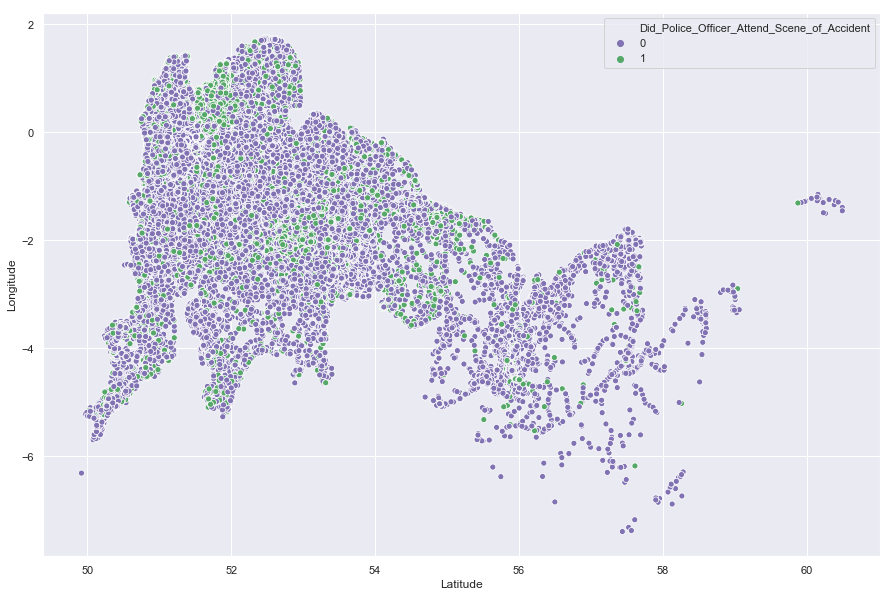

In [10]:
plt.figure(figsize=(15,10))
sns.set(style="ticks", palette="pastel")
sns.set(font_scale=1)
g=sns.scatterplot(x='Latitude', y='Longitude', data=input_data, hue='Did_Police_Officer_Attend_Scene_of_Accident', palette=["m", "g"]);

It's evident that we have some redundant variables from a modeling perspective. Given that we have limited time to work on this, let's select features with higher hierarchical order. i.e features like **1st_Road_Number 2nd_Road_Number** would be substituted by **1st_Road_Class**. We'll drop the **Accident_Index** feature as it's mostly and ID type feature.

What's the relationship between the severity of an accident and whether or not the police attended the accident? To answer this question, let's look at the **Chi-Squared** test of association between the two. We can do this for other variables in the data set, but we'll stop with this variable due to time constraint.

In [11]:
contingency_table = pd.crosstab(
    input_data['Accident_Severity'],
    input_data['Did_Police_Officer_Attend_Scene_of_Accident'],
    margins = True
)
contingency_table
chi2_contingency(contingency_table)

Did_Police_Officer_Attend_Scene_of_Accident,0,1,All
Accident_Severity,,,
1,1534,160,1694
2,18119,3450,21569
3,84072,27473,111545
All,103725,31083,134808


(938.6986060421891,
 1.614360749440995e-199,
 6,
 array([[  1303.41040591,    390.58959409,   1694.        ],
        [ 16595.78456026,   4973.21543974,  21569.        ],
        [ 85825.80503383,  25719.19496617, 111545.        ],
        [103725.        ,  31083.        , 134808.        ]]))

There's indeed a strong association between the two.

In [12]:
to_drop = ['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', '1st_Road_Number', '2nd_Road_Number','LSOA_of_Accident_Location']
len(to_drop)
input_data.drop(to_drop, axis=1, inplace=True)

6

### Feature Engineering
Given the limited time we have to work on this, we'll not spent too much time on exhaustive engineering of new features. Automated feature engineering methods using tools like featuretools is a good option but we'll go about it ourselves for now. We'll also cluster the longitude and latitude into categories using the Kmeans algorithm as part of feature engineering.

In [13]:
input_data['Hour']  = input_data['Time'].apply(lambda x: str(x)[0:2])
input_data['Month'] = input_data['Date'].apply(lambda x: str(x)[3:5])
input_data['casualty_group'] = pd.cut(input_data['Number_of_Casualties'], bins = pd.IntervalIndex.from_tuples([(0.99, 3), (3.99, 9), (9.99, 58)]), labels=['low','medium','high'])
input_data = input_data.join(input_data.groupby('Month')['Police_Force'].mean(), on='Month', rsuffix='_Monthly_Average')
input_data = input_data.join(input_data.groupby('Day_of_Week')['Police_Force'].mean(), on='Day_of_Week', rsuffix='_Weekly_Average')
input_data = input_data.join(input_data.groupby('Month')['Speed_limit'].mean(), on='Month', rsuffix='_Monthly_Average')
input_data = input_data.join(input_data.groupby('Month')['Number_of_Casualties'].mean(), on='Month', rsuffix='_Monthly_Average')
input_data['Date'] = pd.to_datetime(input_data['Date'])
input_data.sort_values('Date', ascending=False, inplace=True)
input_data['cumsum_Number_of_Casualities'] = np.cumsum(input_data['Number_of_Casualties'])
input_data.reset_index(inplace=True, drop=True)
input_data.head()

,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Coordinates,Hour,Month,casualty_group,Police_Force_Monthly_Average,Police_Force_Weekly_Average,Speed_limit_Monthly_Average,Number_of_Casualties_Monthly_Average,cumsum_Number_of_Casualities
0,-0.259,52.087,40,2,1,1,2016-12-31,7,17:43,424,E06000056,3,6,30.000,0,-1,-1,0,1,4,1,2,0,0,1,1,"(52.086574, -0.259033)",17,12,"(0.99, 3.0]",30.201,29.959,37.721,1.327,1
1,-0.185,51.483,1,3,1,1,2016-12-31,7,04:20,12,E09000020,3,6,30.000,6,2,3,0,5,4,1,1,0,0,1,0,"(51.483163, -0.1855)",04,12,"(0.99, 3.0]",30.201,29.959,37.721,1.327,2
2,-0.185,50.848,47,3,2,1,2016-12-31,7,13:30,565,E06000043,3,6,30.000,6,2,6,0,0,1,1,2,0,0,1,1,"(50.847611, -0.184974)",13,12,"(0.99, 3.0]",30.201,29.959,37.721,1.327,3
3,-0.412,50.812,47,3,3,1,2016-12-31,7,12:30,564,E10000032,3,6,40.000,3,4,6,0,0,1,1,1,0,0,1,0,"(50.812441, -0.41212600000000005)",12,12,"(0.99, 3.0]",30.201,29.959,37.721,1.327,4
4,-0.705,50.819,47,3,1,1,2016-12-31,7,18:31,559,E10000032,6,6,30.000,0,-1,-1,0,0,6,1,2,0,0,2,0,"(50.818746000000004, -0.704791)",18,12,"(0.99, 3.0]",30.201,29.959,37.721,1.327,5


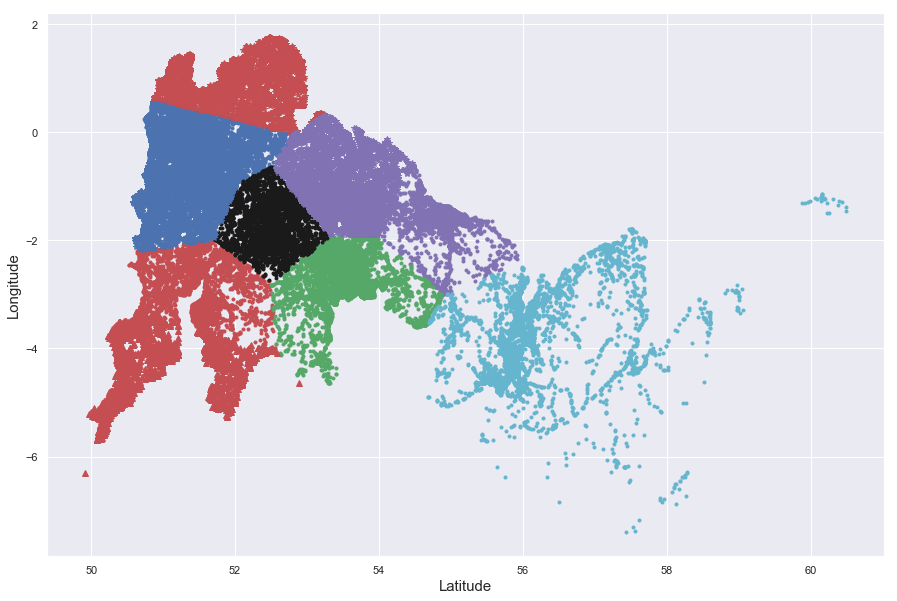

In [14]:
X = input_data.loc[:, ['Latitude','Longitude']]
#run KMeans
cluster_size = 10
kmeans_fit = KMeans(n_clusters=cluster_size, random_state=0).fit(X)
id_label=kmeans_fit.labels_

#plot result
ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^']);
plt.figure(figsize=(15,10))
plt.ylabel('Longitude', fontsize=15)
plt.xlabel('Latitude', fontsize=15)
for i in range(cluster_size):
    cluster=np.where(id_label==i)[0]
    plt.plot(X.Latitude[cluster].values, X.Longitude[cluster].values, ptsymb[i])
plt.show()
input_data['geo_loc'] = id_label.astype(int)
input_data.drop(['Longitude', 'Latitude', 'Time', 'Date', 'Coordinates'], axis=1, inplace=True);

That doesn't look bad at all. It should represent all Geo-location related variables so that we can drop them for now, but in a real project, further investigations of those variables would be warranted. We'll validate all new features during the feature selection step. But let's quickly check below how useful the monthly speed limit average is. 

In [15]:
input_data.loc[input_data['Did_Police_Officer_Attend_Scene_of_Accident'] == 0, 'Speed_limit_Monthly_Average'].var()
input_data.loc[input_data['Did_Police_Officer_Attend_Scene_of_Accident'] == 1, 'Speed_limit_Monthly_Average'].var()

0.17882989936372082

0.1778917997270526

In [16]:
ttest_ind(input_data.loc[input_data['Did_Police_Officer_Attend_Scene_of_Accident']    == 0, 'Speed_limit_Monthly_Average'], input_data.loc[input_data['Did_Police_Officer_Attend_Scene_of_Accident'] == 1, 'Speed_limit_Monthly_Average'], equal_var=True)
mannwhitneyu(input_data.loc[input_data['Did_Police_Officer_Attend_Scene_of_Accident'] == 0, 'Speed_limit_Monthly_Average'], input_data.loc[input_data['Did_Police_Officer_Attend_Scene_of_Accident'] == 1, 'Speed_limit_Monthly_Average'])

Ttest_indResult(statistic=-3.6740000435764215, pvalue=0.00023887506866748738)

MannwhitneyuResult(statistic=1599790610.0, pvalue=0.02053320292711416)

Based on the above tests, it looks like those features are helpful in differentiating the outcome. We'll revisit these during data pre-processing/selection in the sections below.

### Additional Data Wrangling & Feature Selection
We will use recursive feature elimination (RFE) as our feature selection strategy. The advantage of this approach is that it looks at important feature as whole as oppose to univariate feature selection. The drawback is that it can be computationally expensive. For that reason, we'll first do a stratified random 50 % split of the training data. The input data is somewhat unbalance in regard to the target variable. A good estimator here would be Random Forest.

Before we do that let's first split our data data into training and testing sets and insure proper encoding of some of our features. We'll use **LabelEncoder** although this kind of limit ourselves to tree based models during the model building step, but that's fine for now.

There are about 37 data points with missing values that need to be imputed. As you can see below the speed limit variable that has all the missing values is far from being normally distributed. We'll either use the median or propagate the last non-missing value to fill all missing values. The latter kind of makes sense giving that for a giving time at a given place, people tend to drive at a relatively similar speed.

38.045351002812176

30.0

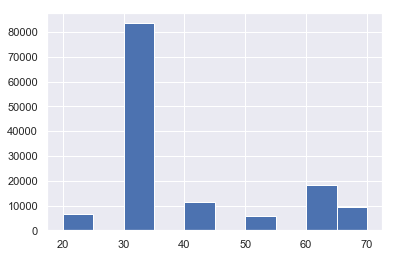

In [17]:
input_data['Speed_limit'].hist()
input_data['Speed_limit'].mean()
input_data['Speed_limit'].median()

In [18]:
input_data['Hour'] = input_data['Hour'].apply(lambda x: np.nan if x == 'na' else x)
input_data[['Speed_limit', 'Hour']] = input_data[['Speed_limit', 'Hour']].ffill()
input_data['Hour'] = input_data['Hour'].astype(int)
input_data['Month'] = input_data['Month'].astype(int)
input_data['Local_Authority_(Highway)'] = input_data['Local_Authority_(Highway)'].astype(str)
input_data['casualty_group'] = input_data['casualty_group'].astype(str)
input_data[pd.isnull(input_data).any(1)]

,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Hour,Month,casualty_group,Police_Force_Monthly_Average,Police_Force_Weekly_Average,Speed_limit_Monthly_Average,Number_of_Casualties_Monthly_Average,cumsum_Number_of_Casualities,geo_loc


In [19]:
X_train_f, X_test, Y_train_f, Y_test = train_test_split(input_data.drop(['Did_Police_Officer_Attend_Scene_of_Accident'], axis=1), input_data['Did_Police_Officer_Attend_Scene_of_Accident'],  
                                                    test_size=0.2, random_state=42, stratify = input_data['Did_Police_Officer_Attend_Scene_of_Accident'])

X_train, X_val, Y_train, Y_val = train_test_split(X_train_f, Y_train_f,  test_size=0.2, random_state=42, stratify = Y_train_f)

In [20]:
#define encoding scheme
d = defaultdict(LabelEncoder)
# Encode the variable
fit = X_train[['Local_Authority_(Highway)', 'casualty_group']].apply(lambda x: d[x.name].fit_transform(x))
X_train.loc[:, ['Local_Authority_(Highway)', 'casualty_group']] = fit.loc[:, ['Local_Authority_(Highway)', 'casualty_group']]
#Using the dictionary to label test, validatation, and other data
X_test.loc[:, ['Local_Authority_(Highway)', 'casualty_group']] = X_test[['Local_Authority_(Highway)', 'casualty_group']].apply(lambda x: d[x.name].transform(x)).loc[:, ['Local_Authority_(Highway)', 'casualty_group']]
X_val.loc[:, ['Local_Authority_(Highway)', 'casualty_group']] = X_val[['Local_Authority_(Highway)', 'casualty_group']].apply(lambda x: d[x.name].transform(x)).loc[:, ['Local_Authority_(Highway)', 'casualty_group']]

In [21]:
X_tr, X_tt, Y_tr, Y_tt = train_test_split(X_train, Y_train, test_size=0.9, random_state=42, stratify = Y_train)

In [22]:
#Using RF as a base estimator
estimator = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample', min_samples_split=50, n_estimators=50)
selector = RFECV(estimator=estimator, cv=10, step=1, n_jobs=-1)
selector = selector.fit(X_tr, Y_tr)
#selected features
selected_features = list(X_train.columns[selector.get_support(indices=True)])
len(selected_features)
np.setdiff1d(list(X_train) , selected_features)

26

array(['Carriageway_Hazards', 'Pedestrian_Crossing-Human_Control',
       'Special_Conditions_at_Site', 'casualty_group'], dtype='<U39')

The **casualty_group** feature we created,**Carriageway_Hazards**, **Special_Conditions_at_Site**,  and **Pedestrian_Crossing-Human_Control** don't seem to be that relevant.

### Modeling 

In [23]:
rfc=RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample', min_samples_split=2, n_estimators=50)

In [24]:
param_grid = {
    'min_samples_split': [150, 200, 250, 300],
    'n_estimators' : [50],
    'max_depth': [None],
    'max_features': ['auto']
}

scorers = {
    #'sensitivity_score': make_scorer(recall_score(pos_label=0)),
    'recall_score': make_scorer(recall_score),
    'roc_auc_score': make_scorer(roc_auc_score)
}

In [25]:
def grid_search_wrapper(refit_score='recall_score', model=rfc, grid_search=param_grid,
                        X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(model, grid_search, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, Y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_val.values)
    print(grid_search.score(X_val.values, Y_val))

    print('\nBest params for {}'.format(refit_score))
    
    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_true=Y_val, y_pred=y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    print(classification_report(y_pred=y_pred, y_true=Y_val))
    return grid_search

In [26]:
grid_search_clf = grid_search_wrapper(refit_score='roc_auc_score', model=rfc, grid_search=param_grid,
                                      X_train=X_train[selected_features], Y_train=Y_train, X_val=X_val[selected_features],
                                      Y_val=Y_val)

0.6974572070393599

Best params for roc_auc_score

Confusion matrix of Random Forest optimized for roc_auc_score on the test data:
     pred_neg  pred_pos
neg     11674      4923
pos      1534      3439
             precision    recall  f1-score   support

          0       0.88      0.70      0.78     16597
          1       0.41      0.69      0.52      4973

avg / total       0.77      0.70      0.72     21570



In [27]:
grid_search_clf.best_params_
grid_search_clf.best_score_
#grid_search_clf.cv_results_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 250,
 'n_estimators': 50}

0.6981470720082816

In [28]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_recall_score', 'param_max_features', 'param_n_estimators', 'param_min_samples_split', 'param_max_depth']].round(3)

,mean_test_recall_score,param_max_features,param_n_estimators,param_min_samples_split,param_max_depth
3,0.693,auto,50,300,None
2,0.693,auto,50,250,None
1,0.685,auto,50,200,None
0,0.677,auto,50,150,None


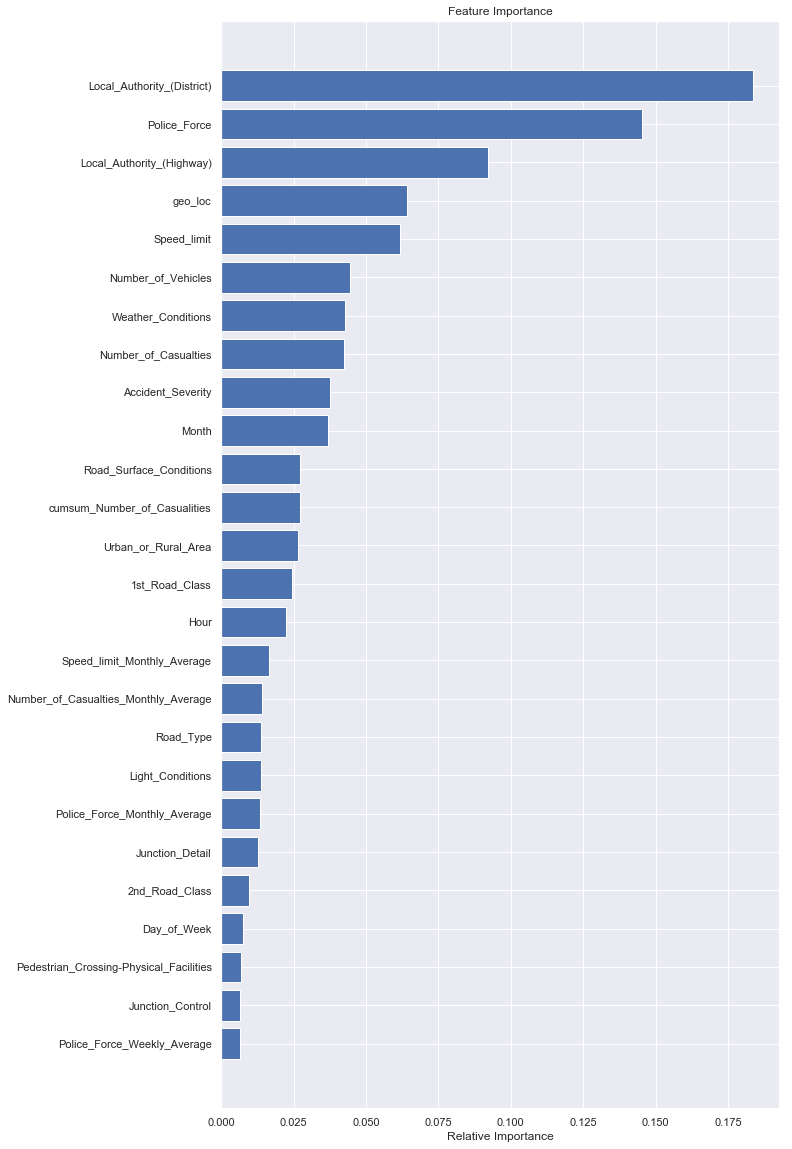

In [29]:
features = list(X_train[selected_features].columns)
plt.figure(figsize=(10,20))
importances = grid_search_clf.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show();

## Modeling - Reduced Feature Set

Let's run another model using a subset of the selected features sets. The reason for this is because we're seeing some features with very low impact features based on the feature importance plot above. We'll go with this simpler model if its ROC is equal or better than the one above.

In [30]:
to_remove = ['Police_Force_Weekly_Average', 'Junction_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Day_of_Week',
             '2nd_Road_Class', 'Junction_Detail','Police_Force_Monthly_Average','Light_Conditions', 'Road_Type',
             'Number_of_Casualties_Monthly_Average', 'Speed_limit_Monthly_Average']
len(to_remove)
selected_features_two =  list(set(selected_features).difference(set(to_remove)))

11

In [31]:
grid_search_clf_reduced = grid_search_wrapper(refit_score='roc_auc_score',X_train=X_train[selected_features_two], X_val=X_val[selected_features_two],
                                           Y_train=Y_train, Y_val=Y_val, grid_search=param_grid)

0.6962063359287832

Best params for roc_auc_score

Confusion matrix of Random Forest optimized for roc_auc_score on the test data:
     pred_neg  pred_pos
neg     11786      4811
pos      1580      3393
             precision    recall  f1-score   support

          0       0.88      0.71      0.79     16597
          1       0.41      0.68      0.51      4973

avg / total       0.77      0.70      0.72     21570



We got almost exact ROC and recall scores with both models. But the second model has the advantage of being simpler so we'll go with that for the time being

In [32]:
results = pd.DataFrame(grid_search_clf_reduced.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_recall_score', 'param_max_features', 'param_n_estimators', 'param_min_samples_split', 'param_max_depth']].round(3)

,mean_test_recall_score,param_max_features,param_n_estimators,param_min_samples_split,param_max_depth
3,0.696,auto,50,300,None
2,0.694,auto,50,250,None
1,0.692,auto,50,200,None
0,0.688,auto,50,150,None


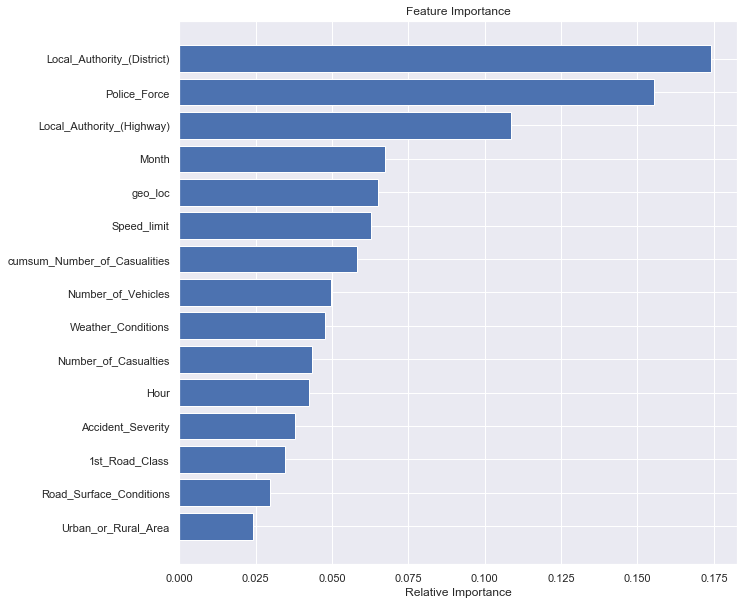

In [33]:
importances = grid_search_clf_reduced.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,10))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [selected_features_two[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show();

The second model with more than half the initial feature set has exactly the same **ROC_AUC** and **Recall** as the first one. Because it's simpler model, we choose that as our final model.

It looks like the district and the police force are one of the most important features in determining whether police will attend an accident or not. If we have more time, I'll investigate what are unique about the different districts. For that we'll probably need an additional data source. But My guess is that police would be more likely to attend an accident if it happens in a richer district.

Also it makes sense to assume that the larger the police force the more likely they're to attend an accident. Again this would need to be double check, maybe with an experiment because feature importance doesn't give us the direction of the relationship between these features and the outcome.

In [34]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(Y_val, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0., 1.01]);
    plt.xlim([0., 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    #save_fig(fig_id='Precision_Recal')

In [35]:
 y_scores = grid_search_clf_reduced.predict_proba(X_val[selected_features_two])[:, 1]

In [36]:
#Generate the precision-recall curve for the classifier
p, r, thresholds = precision_recall_curve(Y_val, y_scores)

     pred_neg  pred_pos
neg     11786      4811
pos      1580      3393


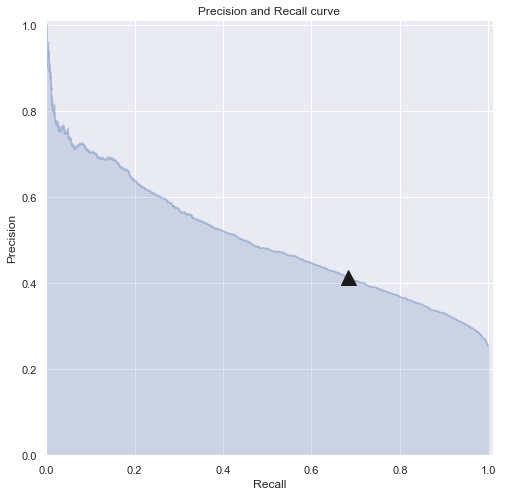

In [37]:
precision_recall_threshold(p, r, thresholds, 0.5)

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    This function generates the precision and recall against some threshold values.
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
#    save_fig(fig_id='precision_recall_vs_threshold')

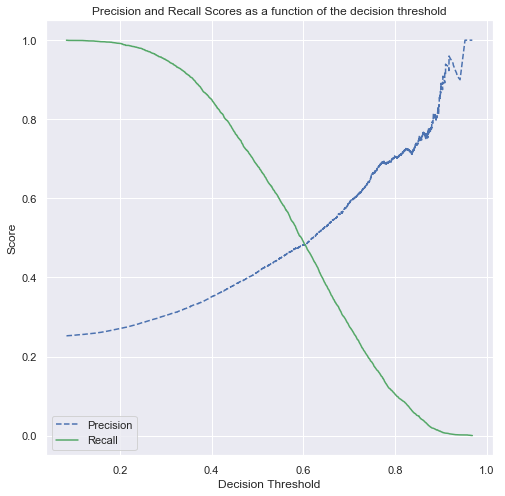

In [39]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    This function plots ROC curve
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
#    save_fig('roc_curve')

0.7747904115737061

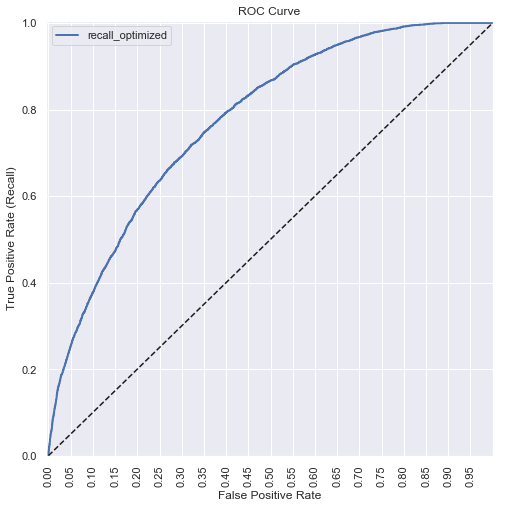

In [41]:
fpr, tpr, auc_thresholds = roc_curve(Y_val, y_scores)
auc(fpr, tpr) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [42]:
def cutoff_predict(clf=grid_search_clf_reduced, X=X_val, y=Y_val, cutoff=.5):
    pr = clf.predict_proba(X)[: ,1]
    p = (pr >= cutoff).astype(int)
    sens = recall_score(y, p, pos_label=1)
    spec = recall_score(y, p, pos_label=0)
    auc  = roc_auc_score(y, pr)
    return sens, spec, auc

In [43]:
s=[]
for cut in np.arange(0.1,0.9,0.0125):
    r = cutoff_predict(grid_search_clf_reduced, X_val[selected_features_two], Y_val, cut)
    if r[0] >= 0.8 and r[1] >= 0.40:
        sens = r[0]
        spec = r[1]
        s.append([r[0], r[1], cut])

In [44]:
s

[[0.9229841142167705, 0.4087485690184973, 0.3374999999999999],
 [0.9109189623969435, 0.4318852804723745, 0.35],
 [0.8982505529861251, 0.45622702898114115, 0.36249999999999993],
 [0.8821636838930224, 0.4779779478218955, 0.3749999999999999],
 [0.8648702996179368, 0.5034042296800627, 0.38749999999999996],
 [0.8501910315704806, 0.5296137856239079, 0.3999999999999999],
 [0.8282726724311281, 0.5547388082183528, 0.4125],
 [0.8113814598833702, 0.5792010604326083, 0.42499999999999993]]

At a cutoff of 0.33 we get a model with a sensitivity (recall) of about 92% and a specificity (true negative) of 40%. An additional business context information, priorities or resources would help choice the right cutoff. 

Now let's validate all the above on the our test set. We only have shot!

In [45]:
s.sort(key=lambda x: x[1], reverse=False)
best_cutoff = s[0][2]
best_cutoff

0.3374999999999999

In [46]:
cutoff_predict(grid_search_clf_reduced, X_test[selected_features_two], Y_test, best_cutoff)

(0.9181277143316712, 0.4126295492889853, 0.7730310219690504)

Waoh! That's a pretty stable model. We got comparable results between our validation and test sets. That looks good.

## Final Model 
Now that we have the optimal values of our models parameters, let's train our final model using **all** of our data in order to make predictions on the validation data that came with the challenge

In [51]:
#from multiscorer import MultiScorer

In [52]:
rfc_f =RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample', 
                              n_estimators=500, max_features='auto', min_samples_split=300)

def cv_final_tain(rfc_f, X_train, Y_train):
    """
    fits a CV classifier using parameters used during model optimazation and use it to predict the validation set of the challenge
    """
    scorer = MultiScorer({
    'sens' : (recall_score, {'pos_label': 1}),
    'spec' : (recall_score, {'pos_label': 0}),
    'roc_auc' : (roc_auc_score, {})
})
    cross_val_score(rfc_f, X=X_train, y=Y_train, cv=StratifiedKFold(n_splits=10), scoring=scorer)
    
    results = scorer.get_results()                                      

    for metric in results.keys():                                       
        print("%s: %.3f %.3f" % (metric, np.mean(results[metric]), np.std(results[metric])*2 ))
    
    # make the predictions on test set
    rfc_f.fit(X_train, Y_train)
    
    return rfc_f

In [53]:
X_train_f = pd.concat([X_train, X_test], ignore_index=True)
Y_train_f = pd.concat([Y_train, Y_test], ignore_index=True)
rfc_fit = cv_final_tain(rfc_f, X_train=X_train[selected_features_two], Y_train=Y_train)

sens: 0.696 0.021
spec: 0.697 0.012
roc_auc: 0.696 0.009
